### 프로젝트: sentencepiece  사용하기



In [4]:
#라이브러리 import

import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
#train & test 데이터 받아오기

urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7f88f9c00d90>)

In [6]:
# train & test 데이터 저장

train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [7]:
#데이터 갯수 확인

print('훈련용 리뷰 개수 :',len(train_data))
print('테스트 리뷰 개수 :',len(test_data))

훈련용 리뷰 개수 : 150000
테스트 리뷰 개수 : 50000


In [9]:
#  테스트 데이터 다운 및 확인

import os
path_to_file = os.getenv('HOME')+'/aiffel/text_preprocess/ratings_train.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 150001
Example:
>> id	document	label
>> 3989148	약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.	1
>> 4805788	이 영화가 왜 이렇게 저평가 받는지 모르겠다	1
>> 8317483	백봉기 언제나오나요?	1
>> 9801316	아햏햏 아햏햏 아햏햏.	1


문장의 최단 길이: 8
문장의 최장 길이: 168
문장의 평균 길이: 45


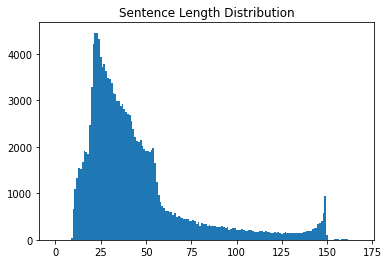

In [17]:
# 자연어 데이터 확인: 
# 아래 소스는 문장의 최단 길이, 최장 길이, 평균 길이를 구한 후 문장 길이 분포를 막대그래프로 표현해 주는 소스입니다. 
# raw 변수는 앞서 다운로드받은 데이터가 담긴 변수입니다!

min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

보니까 id랑 label은 단어사전을 만드는데 방해가 될 것으로 판단. 따라서 이를 지우고 document만 모으고자 함.

In [11]:
train_data_document = train_data['document']
print(train_data_document)

0                                       아 더빙.. 진짜 짜증나네요 목소리
1                         흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
2                                         너무재밓었다그래서보는것을추천한다
3                             교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정
4         사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...
                                ...                        
149995                                  인간이 문제지.. 소는 뭔죄인가..
149996                                        평점이 너무 낮아서...
149997                      이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?
149998                          청춘 영화의 최고봉.방황과 우울했던 날들의 자화상
149999                             한국 영화 최초로 수간하는 내용이 담긴 영화
Name: document, Length: 150000, dtype: object


In [12]:
# train data document EDA 1 : 중복제거

# document 열과 label 열의 중복을 제외한 값의 개수
train_data_document.nunique()

146182

150,000개에서 대략 4,000개가 중복되어있음. 따라서 중복된 샘플을 제거함.

In [14]:
# document 열의 중복 제거
train_data_document.drop_duplicates(inplace=True)
print('총 샘플의 수 :',len(train_data_document))

총 샘플의 수 : 146183


In [15]:
# train data document EDA 2 : null값 제거
train_data_document = train_data_document.dropna(axis=0) #결측치 제거 코드
print(train_data_document.isnull().values.any())
print('EDA 1,2 이후 총 샘플의 수 :',len(train_data_document))

False
EDA 1,2 이후 총 샘플의 수 : 146182


In [18]:
# txt파일로 저장 및 인덱스 없애기
train_data_document.to_csv('train_data_document.txt', sep = '\t', index = False)

In [19]:
# 정제된 테스트 데이터 다운 및 확인

import os
path_to_file = os.getenv('HOME')+'/aiffel/text_preprocess/train_data_document.txt'

with open(path_to_file, "r") as f:
    raw = f.read().splitlines()

print("Data Size:", len(raw))

print("Example:")
for sen in raw[0:100][::20]: print(">>", sen)

Data Size: 146183
Example:
>> document
>> 약탈자를 위한 변명, 이라. 저놈들은 착한놈들 절대 아닌걸요.
>> 이 영화가 왜 이렇게 저평가 받는지 모르겠다
>> 백봉기 언제나오나요?
>> 아햏햏 아햏햏 아햏햏.


문장의 최단 길이: 1
문장의 최장 길이: 158
문장의 평균 길이: 36


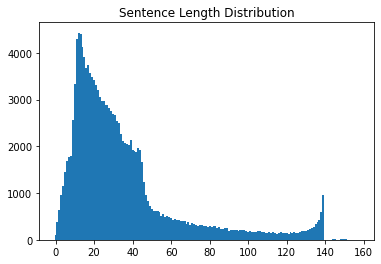

In [20]:
min_len = 999
max_len = 0
sum_len = 0

for sen in raw:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(raw))

sentence_length = np.zeros((max_len), dtype=int)

for sen in raw:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

In [22]:
#EDA 3: 문장길이와 분포에 따른 이상치 탐지 (길이가 1인 문장 확인)

def check_sentence_with_length(raw, length):
    count = 0
    
    for sen in raw:
        if len(sen) == length:
            print(sen)
            count += 1
            if count > 100: return

check_sentence_with_length(raw, 1)

아
잼
1
4
굿
짱
휴
.
음
?
ㅎ
ㅋ
즐
♥
굳
네
ㅇ
k
ㅠ
쒯
♬
토
O
똥
z
헐
삼
꽝
!
풉
ㅅ
왜
ㄴ
쉣
봐
뿌
ㅜ
♡
ㅁ
0
ㅉ
d
흥
乃
찜
귯
린
시
ㅗ
a
c
흠
웅
ㅣ
오
9
쩜
애
헝
쨩
f
움
ㄳ
업
헉
군
b
;
g
올
걍
허
-
쀍
로
ㄹ
ㅂ
갑
즛
킥
함
진
ㅡ
잠
곧
ㅍ
h
·
캬
ㅆ
,
풋
ㄱ
파
ㄷ
웩
꺅
욜
ㅄ
2
핡


In [26]:
#너무 짧은 문장은 이상한 댓글이 많은듯... 5개짜리로 한번 더 확인
check_sentence_with_length(raw, 5)

재미있어요
전 좋아요
아 빵점~
ㅠㅠ 슬픔
최고의영화
잘봤습니다
쓰레기영화
볼만 한데
짝퉁쓰래기
잼없네요넘
재밌따!!
반지의제왕
ㅄ같은영화
옛다 평점
글쎄...
8점만들자
재밌군..
할말 없음
좋다...
좋았다..
시시하다.
완벽하다!
또보고싶은
완존재밌어
이건뭐..
결말 ㅠㅠ
실망이다.
사랑한다.
쓰레기ㅡㅡ
에이 모야
재밌었어요
가슴 아픔
아나 ㅠㅠ
쩌는듯ㅇㅇ
재미없어요
최고~^^
시간아까워
재밋어요~
잼난다..
재밌나여?
눈물나다.
OO하네2
과연?ㅋㅋ
원주율ㅋㅋ
따분하다.
솔직합니다
휴우...
더러운영화
재미없네.
너무 젬슴
쫌 웃겼다
짱이야~~
좋습니다.
재밌네 ,
남자란..
순수!!!
이상한내용
dㅇㅅㅇb
코믹인가?
멋진 영화
약한 웃음
명작이다.
굿~~!!
good!
참나...
떡실신..
뭐야 이거
짱~~~~
코..콩!
와..잼따
제점수는요
감동??ㅋ
재밌습니다
안경벗어!
택시 기사
재미있당.
짱 재밌음
굿 ㅠㅡㅠ
쓰레기같다
정말재밌다
완전 짱~
안타깝네요
으리!!!
즈질 안봐
좋구만 ♡
잼 없음.
안봐서모름
잼있다~~
볼만하던데
선동선동해
좀 아쉬운
이런젠장!
할말없네요
아 ...
재미..x
그냥 최고
넘길어..
어떨가나?
잘된 영화
두근두근~
보다 껏다


In [29]:
# 5개짜리는 의미있는 내용이 꽤 있네... 그러면 2개정도는 어떨까?
check_sentence_with_length(raw, 2)

최고
졸작
대박
버려
망함
굳굳
안습
망작
ㅇㅇ
쵝오
굿!
별루
씐나
쓰렉
볼만
허접
비추
좋다
ㅎㅎ
아나
ㅉㅉ
야.
역시
^^
오오
평이
지루
오욈
ㅋㅋ
지송
별로
눈물
당연
쩔어
별노
몰입
졸잼
돋네
오글
이응
첨봄
최악
잼씀
ok
유후
감동
gg
;;
조앙
1점
표절
명작
으휴
에효
ㄱ굿
굿잡
잼나
10
ㅜㅜ
우왕
거지
굿굿
좋음
실망
굿.
애이
짱임
전설
mm
와우
등록
하위
그닥
뭉클
삼류
HN
윤하
섹시
실화
머냐
수작
꿀잼
동감
dd
굳ㅋ
굳!
추천
좋아
55
안봐
개쩜
올레
난해
ㅠㅠ
뭐니
ㅁㅁ
뭥미
쓰랙
좇~
오우
미안


In [25]:
# 별로 의미없는 문장을 걸러보자

for idx, _sum in enumerate(sentence_length):
    # 문장의 수가 4000을 초과하는 문장 길이를 추출합니다.
    if _sum > 4000:
        print("Outlier Index:", idx+1)

Outlier Index: 12
Outlier Index: 13
Outlier Index: 14
Outlier Index: 15


In [30]:
check_sentence_with_length(raw, 12) #긴 데이터들이 이상치인지 확인해봤지만, 이상치로 판단하기는 무리가 있음.

아햏햏 아햏햏 아햏햏.
단연 최고라고 할수있지
용가리 진짜짱짱맨이다ㅋ
나름 괜찮은 작품입니다
정말 실망 스러웟음..
무술인이 왜 총을드나?
너무너무 훈훈하네요^^
현실은 꿈, 꿈은 현실
답없네, 뭐하는건지..
엔딩이 넘 슬퍼요 :(
감동감동감동의 도가니탕
정말 최고의 영화...
진짜 짜증나는 영화..
상당히 재밌게 봤습니다
영상미가 역시 최고네요
감독ㅡㅡ다신영화찍지마라
이런 영화가 참 좋다.
정말 광해와 비슷한가?
더빙이 똥이야 ....
잠을 청할 수 있었다.
나오코 진짜 집중안된다
샬라샬라 나오다즁자쥬아
지루하다.. 지루해..
사과해요, 나한테!!!
소재가 굉장히 신선했다
솔직히 산만 하기만했다
OST가 좋은 영화!!
기적은 이미 일어났다.
답을 알려고 하지마라.
평점은 믿지마셈 재밌음
재미 드럽게 없다ㅋㅋㅋ
자식을 그렇게 때리냐?
감동적이였고 좋았습니다
울컥하는 사회현실 ㅠㅠ
등장인물들 모두 짱~~
막장드라마가 따로없구만
말 필요엄따~~~~진정
꿀잼 영화 추억이다ㅜㅜ
맞추자 ㅍ?차븟ㅇㄱ디시
순수하고 아름답다 :)
변태적 성욕 자기합리화
흠....나름 갠찬네요
걍 10점 이라길래..
실력이 필요없는 상황.
감동과 웃음을 한방에!
이거야 이거 ㅋㅋㅋㅋㅋ
성동일딸 시르다...참
평점알바들을 위해 1점
볼만합니다 강추!!ㅋㅋ
이거말고 겨울왕국을봐라
좋은니다..^.,^~~
2.3 (10자 제한)
아무도 안달았네..ㄷㄷ
엉성하고 어설프고...
그냥 보통으로 보았다.
너무 슬픈영화..울음ㅠ
으리는 개뿔 ㅡ,.ㅡ^
처음 본 에로 영화..
평점 조정을 위해...
그냥 쓰레기지 쓰레기~
쵝오네요 최고 대박영화
유전무죄 무전유죄!!!
의외의 꿀잼 이였습니다
어차피 우승은 송민호~
이 때부터가 쓰레기였지
완전 찝찝한 영화...
이상형이 바뀌었습니다.
역시 산드라블록 누님!
결국 엄마가 죽인거네?
그냥 그저 별시리...
추천할만한 경제영화였음
제대로 알아야할 역사임
일본판이더재미있음...
역시 재미있군요 >ㅁ<
아깝다 나의 1점도ㅡㅡ
마음이 따뜻해지는 영화
죽었다. 참 재미없다.

Data Size: 146183
문장의 최단 길이: 1
문장의 최장 길이: 158
문장의 평균 길이: 36


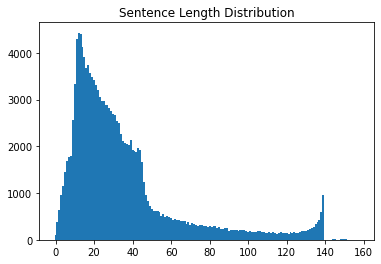

In [33]:
#중복제거 코드

min_len = 999
max_len = 0
sum_len = 0

cleaned_corpus = list(set(raw))  # set를 사용해서 중복을 제거합니다.
print("Data Size:", len(cleaned_corpus))

for sen in cleaned_corpus:
    length = len(sen)
    if min_len > length: min_len = length
    if max_len < length: max_len = length
    sum_len += length

print("문장의 최단 길이:", min_len)
print("문장의 최장 길이:", max_len)
print("문장의 평균 길이:", sum_len // len(cleaned_corpus))

sentence_length = np.zeros((max_len), dtype=int)

for sen in cleaned_corpus:   # 중복이 제거된 코퍼스 기준
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

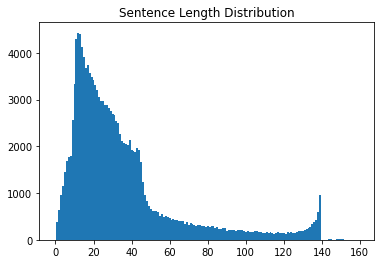

In [37]:
# 너무 길거나 짧은 데이터 Padding 처리

max_len = 160 #긴데이터 살릴필요있음, 미니멈이 2인 이유는 위에서 확인했음.
min_len = 2

# 길이 조건에 맞는 문장만 선택합니다.
filtered_corpus = [s for s in cleaned_corpus if (len(s) < max_len) & (len(s) >= min_len)]

# 분포도를 다시 그려봅니다.
sentence_length = np.zeros((max_len), dtype=int)

for sen in filtered_corpus:
    sentence_length[len(sen)-1] += 1

plt.bar(range(max_len), sentence_length, width=1.0)
plt.title("Sentence Length Distribution")
plt.show()

### 1. 공백기반 토큰화(한국어에서 무의미 하나 일단 해봄)

In [38]:
def tokenize(corpus):  # corpus: Tokenized Sentence's List
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
    tokenizer.fit_on_texts(corpus)

    tensor = tokenizer.texts_to_sequences(corpus)

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, tokenizer

In [39]:
#정제된 데이터 filtered_corpus를 공백 기반으로 토큰화하여 저장하는 코드
split_corpus = []

for kor in filtered_corpus:
    split_corpus.append(kor.split())

In [40]:
# 토큰화 후 단어사전(코퍼스)의 길이 확인

split_tensor, split_tokenizer = tokenize(split_corpus)

print("Split Vocab Size:", len(split_tokenizer.index_word))

Split Vocab Size: 357307


In [41]:
#토큰화된 단어 예시 10개까지 확인

for idx, word in enumerate(split_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 10: break

0 : 영화
1 : 너무
2 : 정말
3 : 진짜
4 : 이
5 : 영화.
6 : 왜
7 : 더
8 : 이런
9 : 그냥
10 : 수
11 : 영화를


### 2. 형태소기반 Konlpy 사용 (총 5개 모두 사용)

In [43]:
from konlpy.tag import Mecab

mecab = Mecab()

In [44]:
# 2-1 mecab 사용

def mecab_split(sentence):
    return mecab.morphs(sentence)

mecab_corpus = []

for kor in filtered_corpus:
    mecab_corpus.append(mecab_split(kor))
    
    
    
#형태소 기반 토큰화의 단어사전길이 확인

mecab_tensor, mecab_tokenizer = tokenize(mecab_corpus)

print("MeCab Vocab Size:", len(mecab_tokenizer.index_word))

MeCab Vocab Size: 53453


In [46]:
for idx, word in enumerate(mecab_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 30: break

0 : .
1 : 이
2 : 는
3 : 영화
4 : 다
5 : 고
6 : 하
7 : 도
8 : 의
9 : 가
10 : 은
11 : 에
12 : 을
13 : 보
14 : 한
15 : ..
16 : 게
17 : ,
18 : 들
19 : !
20 : 지
21 : 를
22 : 있
23 : 없
24 : ?
25 : 좋
26 : 나
27 : 었
28 : 만
29 : 는데
30 : 너무
31 : 봤


In [ ]:
# 2-2 OKT 사용
# Konlpy에서 Okt를 불러옵니다.
from konlpy.tag import Okt

# Okt Class의 생성자를 이용하여 분석기를 생성 
okt = Okt()

def okt_split(sentence):
    return okt.morphs(sentence)

okt_corpus = []

for kor in filtered_corpus:
    okt_corpus.append(okt_split(kor))
    
    
#형태소 기반 토큰화의 단어사전길이 확인

okt_tensor, okt_tokenizer = tokenize(okt_corpus)

print("Okt Vocab Size:", len(okt_tokenizer.index_word))

In [48]:
for idx, word in enumerate(okt_tokenizer.word_index):
    print(idx, ":", word)

    if idx > 30: break

0 : .
1 : 이
2 : 영화
3 : 의
4 : ..
5 : 가
6 : 에
7 : 을
8 : ...
9 : 도
10 : 들
11 : ,
12 : 는
13 : 를
14 : 은
15 : 너무
16 : ?
17 : 한
18 : 다
19 : 정말
20 : 적
21 : 만
22 : 진짜
23 : !
24 : 으로
25 : 로
26 : 점
27 : 에서
28 : 연기
29 : 과
30 : 것
31 : 평점


### 3. sentencepiece 모델 사용

In [52]:
# sentencepiece 모델 사용

import sentencepiece as spm
import os
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp'

vocab_size = 8000 #이거 역할 뭐임?

with open(temp_file, 'w') as f:
    for row in filtered_corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-park.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

-rw-r--r-- 1 root root 374671 Nov  7 07:27 korean_spm.model
-rw-r--r-- 1 root root 144092 Nov  7 07:27 korean_spm.vocab


In [53]:
# sentencepiece 모델 작동 확인

s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces('아버지가방에들어가신다.',1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[1401, 10, 388, 15, 1324, 10, 123, 17, 4]
['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
아버지가방에들어가신다.


In [55]:
#SP모델 적용

def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [59]:
tensor, word_index, index_word = sp_tokenize(s, filtered_corpus)

print("SP Vocab Size:", len(word_index))

SP Vocab Size: 8000
